# 什么是PyTorch？
PyTorch是一个python库，主要提供了两个功能：
1. GPU加速的张量计算
2. 构建在反向自动求导的深度神经网络

## 1.定义数据

In [26]:
import torch

x = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
x

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [27]:
y = torch.tensor(666)
y

tensor(666)

In [28]:
z = torch.tensor([1,2,3])
z

tensor([1, 2, 3])

torch支持多种数据类型，创建时也有多种用法，ones，zeros，rand，normal等

In [29]:
x = torch.empty(5,3)
x

tensor([[1.5842e+26, 1.9086e-42, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [30]:
x = torch.rand(5,3)
x

tensor([[0.9817, 0.8796, 0.9921],
        [0.4611, 0.0832, 0.1784],
        [0.3674, 0.5676, 0.3376],
        [0.2119, 0.4594, 0.8154],
        [0.9157, 0.2531, 0.2133]])

In [31]:
x = torch.zeros(5,3,dtype=torch.long)
x

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [32]:
y = x.new_ones(5,3)
y

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

In [33]:
z = torch.randn_like(x,dtype=torch.float)
z

tensor([[ 0.7098, -1.6195, -0.9109],
        [ 0.7987,  2.2530, -2.5439],
        [-0.6185, -0.6405, -0.2584],
        [ 1.0287, -0.5796, -0.0061],
        [-0.4907,  0.3597, -0.4579]])

## 2.定义操作
用tensor进行各种运算，都是Function，包含
1. 基本运算，加减乘除、求幂求余
2. 布尔运算，
3. 线性运算、矩阵乘法，模、行列式等

In [34]:
m =torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
print(m.size(0), m.size(1), m.size(), sep= ' -- ')

3 -- 3 -- torch.Size([3, 3])


In [35]:
m.numel()

9

In [36]:
m[:,1]

tensor([2, 5, 8])

In [37]:
m[0, :]

tensor([1, 2, 3])

In [38]:
v = torch.arange(1, 4)
v

tensor([1, 2, 3])

In [39]:
m @ v # 矩阵乘法

tensor([14, 32, 50])

In [40]:
m + torch.rand(3,3)

tensor([[1.8827, 2.5490, 3.1045],
        [4.8004, 5.1677, 6.4677],
        [7.4986, 8.2797, 9.7238]])

In [41]:
m.t()

tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])

In [42]:
m.transpose(0, 1)

tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])

In [43]:
torch.linspace(3, 8, 20)

tensor([3.0000, 3.2632, 3.5263, 3.7895, 4.0526, 4.3158, 4.5789, 4.8421, 5.1053,
        5.3684, 5.6316, 5.8947, 6.1579, 6.4211, 6.6842, 6.9474, 7.2105, 7.4737,
        7.7368, 8.0000])

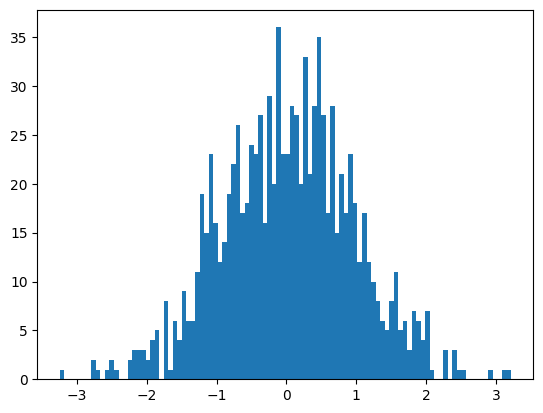

In [44]:
import matplotlib.pyplot as plt

plt.hist(torch.randn(1000).numpy(),bins=100)
plt.show()

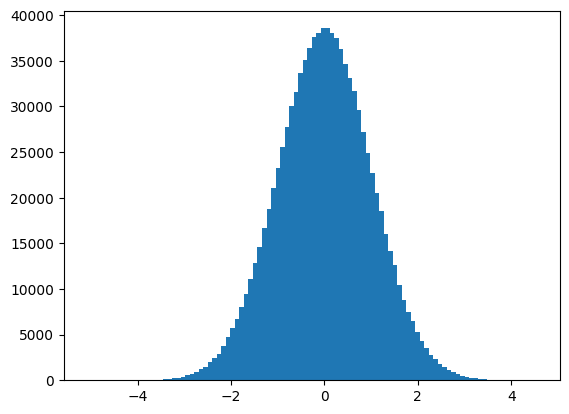

In [45]:
plt.hist(torch.randn(10**6).numpy(),bins=100)
plt.show()

# Spiral Classsifciation


In [51]:
# import
import random
import math 
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from plot_lib import plot_data, plot_model, set_default

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

初始化随机数种子，神经网络参数在初始时是随机的，而不同的初始值会影响神经网络的性能，当我们德奥一个比较好的结果时，我们希望这是可以复现的，因此，在pytorch中通过设置随机数种子来达到这个目的。

初始化X和Y，X是一个特征矩阵，大小为[NxC, D]，Y是样本标签大小为CxN。

In [53]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

N = 1000  # 每类样本的数量
D = 2   # 每类样本的特征维度
C = 3   # 样本类别
H = 100     # 隐藏层单元数量

In [54]:
X = torch.zeros(N * C, D).to(device)
Y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace((2*math.pi/C) * c, (2 * math.pi / C) * (c + 2), N)
    for ix in range(N * c, N * (c+1)):
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]),math.cos(inner_var[index])))
        Y[ix] = c
        index += 1
print('Shapes：')
print(X.size())
print(Y.size())

Shapes：
torch.Size([3000, 2])
torch.Size([3000])


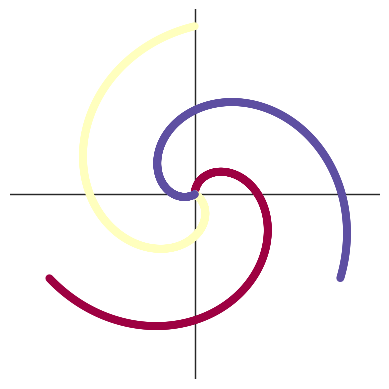

In [55]:
plot_data(X, Y)

## 1.构建线性分类模型

In [69]:
lr = 1e-3
lambda_12 = 1e-5

# nn用于创建模型，每个模型包含weight和bias
model = torch.nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

# loss，本处使用交叉熵函数
critierion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lambda_12)

# 训练
for epoch in range(1000):
    y_pred = model(X)
    loss = critierion(y_pred, Y)
    score, predicted = torch.max(y_pred, 1)
    acc = (predicted == Y).sum().float() / Y.size(0)
    print('[EPROCH]:%i, [LOSS]:%.3f, [ACC]:%.3f' % (epoch, loss.item(), acc))
    display.clear_output(wait=True)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

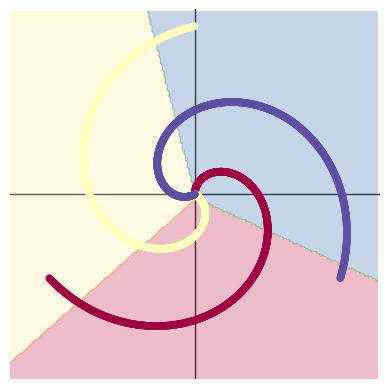

In [68]:
print(model)
plot_model(X, Y, model)

2. 构建两层神经网络（实际上是在原本模型增加ReLU激活函数）

In [81]:
lr = 1e-3
lambda_12 = 1e-5

# nn用于创建模型，每个模型包含weight和bias
model = torch.nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# loss，本处使用交叉熵函数
critierion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lambda_12)

# 训练
for epoch in range(10000):
    y_pred = model(X)
    loss = critierion(y_pred, Y)
    score, predicted = torch.max(y_pred, 1)
    acc = (predicted == Y).sum().float() / Y.size(0)
    print('[EPROCH]:%i, [LOSS]:%.3f, [ACC]:%.3f' % (epoch, loss.item(), acc))
    display.clear_output(wait=True)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


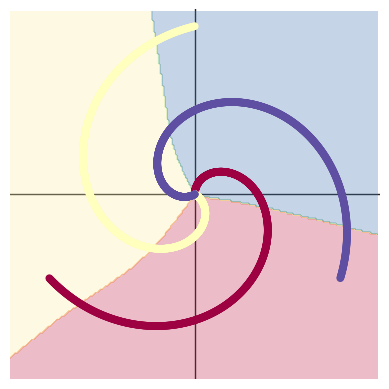

In [82]:
print(model)
plot_model(X, Y, model)

# 问题思考
### 1. AlexNet有什么特点？为什么能够取得比LeNet更好的性能？
答：AlexNet是2012年提出的卷积神经网络模型，包含5个卷积层和3个全连接层，被认为是第一个深度神经网络，是深度学习领域一个重要的里程碑。同时，AlexNet开创性的使用GPU进行网络训练，大大提高了训练速度。相比于早期的LeNet，它还具有以下几个特点
1. 在全连接层使用了Dropout技术，通过随机令部分神经元失活的方式，防止模型过拟合，提高了模型的泛化能力。
2. 使用ReLU函数作为其激活函数，能够有效的解决梯度消失问题，加快网络训练速度。
3. AlexNet能够输入更大的图像，使得模型具有处理图像中细节与复杂信息的能力。

### 2. 激活函数有哪些作用？
答：激活函数在神经元计算中具有非常重要的作用，激活函数模拟了生物神经元的行为，即神经元突触中的电信号达到一定水平时，神经元才会被“激活”并传递信号。同时，激活函数通常选择非线性函数，给神经网络引入了非线性元素，将特征从线性空间映射到非线性空间，非线性激活函数舍得神经网络呢个给对数据进行复杂的转换，能够拟合和结果复杂的非线性问题。常用的激活函数有Sigmoid函数、Tanh函数，ReLU函数等。

### 3. 梯度消失现象是什么？
答：梯度消失问题是指神经网络在训练过程中，损失函数的梯度逐层变小，使得前面的层梯度变得很小甚至为0，导致前几层的权重更新非常缓慢甚至停止，从而影响神经网络的学习效率。梯度消失通常由以下因素造成：
1. 链式法则：在反向传播过程中，损失函数的求导遵循链式求导法则，即某一层的梯度是由许多层的导数相乘得到的，当某一层的梯度小于1时，这个乘积会因误差反向传播越来越小，最终接近于0
2. 激活函数：使用Sigmoid函数与Tanh函数时，由于这个两个函数的输出均小于1，容易导致梯度消失。
有以下集中方法解决梯度消失问题：
1. ReLU函数作为激活函数
2. 引入残差网络
3. 合适的权重初始化
4. 调整学习率

### 4.神经网络是更宽还是更深好？
答：神经网络的深度（层数）与宽度（每层神经元的数量）对模型的训练速度、模型性能都有重要的影响。
更深的神经网络具有更强的特征提取能力，模型的表达能力更强，但是会出现梯度消失或梯度爆炸等问题，同时网络的训练难度也会大幅提升，当数据量不足的时候，也会有过拟合的风险。

更宽的网络意味着每层包含有更多的神经元，训练的稳定性较强，更快的收敛速度，同时宽的神经网络在简单任务上具有很好的表现，因为简单任务的特征在浅层就
能被很好的表达出来，同时更宽的网络会导致参数的大量增加，面对复杂的任务时，宽的神经网络可能不能很好的提取数据中的特征。
综上所述，对于更宽还是更深要针对于任务来考虑。对于复杂任务，深层的神经网络会具有更好的性能，而简单任务使用宽的神经网络以节省资源

### 5. 为什么要使用SoftMax？
SoftMax函数的作用是将神经网络的输出转化为概率分布，方便完成分类的任务。SoftMAx函数表达式如下：
$$ 
\hat{y}_{i}=\frac{e^{z_{i}}}{\sum_{j=1}^{n} e^{z_{j}}}
$$
SoftMax的输出介于0-1之间，被认为是一个概率分布，在多分类任务中，SoftMax的输出可以认为是该样本被分为某类的概率，概率最高的那个类别会被认为是该样本所在的类别。

### 6. SGD与Adam哪个更有效？
SGD（随机梯度下降）是梯度下降算法的一种，它使用随机选取的小批量数据来计算并更新模型的参数，这种随机性引入了一定的噪声，但是也能够加快训练和避免陷入局部最优。SGD算法优化效率高，适合在线学习，但是收敛不稳定且依赖学习率。
Adam（Adaptive Moment Estimation）结合了动量法和RMSProp的优点，通过计算梯度的一阶矩估计和二阶矩估计来自适应的调整学习率。Adam具有自适应学习率、收敛速度快的优点，但是也可能导致过早的收敛。


GitHub：https://github.com/wmingqiang01/DEEPlearning_work.git

欢迎访问我的主页：https://wmingqiang01.github.io/